<a href="https://colab.research.google.com/github/fagonzalezo/sklearn-kdcrf/blob/master/examples/approximation_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup code

In [1]:
# Install kdrcf if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/fagonzalezo/sklearn-kdcrf.git
    !mv sklearn-kdcrf/kdcrf .
    

In [2]:
%matplotlib inline
import pylab as pl
import numpy as np

# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    
    
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    print(X.shape)
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict_proba(x)[0][1]
    return pred_fun

## Kernel approximation for letters

In [3]:
## https://archive.ics.uci.edu/ml/datasets/Letter+Recognition
!pip install wget
import wget
letter = wget.download("https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data")

In [3]:
import pandas as pd
letters = pd.read_csv("letter-recognition.data", header=None)
print(letters.head())
print(letters.describe())

vector_letters = letters.values[:,1:]

  0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0  T   2   8   3   5   1   8  13   0   6   6  10   8   0   8   0   8
1  I   5  12   3   7   2  10   5   5   4  13   3   9   2   8   4  10
2  D   4  11   6   8   6  10   6   2   6  10   3   7   3   7   3   9
3  N   7  11   6   6   3   5   9   4   6   4   4  10   6  10   2   8
4  G   2   1   3   1   1   8   6   6   6   6   5   9   1   7   5  10
                 1             2             3            4             5   \
count  20000.000000  20000.000000  20000.000000  20000.00000  20000.000000   
mean       4.023550      7.035500      5.121850      5.37245      3.505850   
std        1.913212      3.304555      2.014573      2.26139      2.190458   
min        0.000000      0.000000      0.000000      0.00000      0.000000   
25%        3.000000      5.000000      4.000000      4.00000      2.000000   
50%        4.000000      7.000000      5.000000      6.00000      3.000000   
75%        5.000000      9.000000      6

In [4]:
##exact kernel
from sklearn.metrics.pairwise import pairwise_kernels

In [5]:
##approximate kernel RFF
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import mean_squared_error
from kdcrf import RBFSamplerORF
from kdcrf import RBFSamplerSORF
import time


def calculate_mean_square_error(dataset):

    exact_rbf_kernel =  pairwise_kernels(X=dataset, Y=dataset, metric="rbf", gamma=1)

    ratio_d = range(1,10)
    
    n_features = dataset.shape[1]
    
    mse = {}
    classifiers = {'rbf rff': RBFSampler(gamma=2**-2, random_state=1), 
                   'rbf orf': RBFSamplerORF(gamma=2**-1, random_state=1),
                   'rbf sorf': RBFSamplerSORF(gamma=2**-1, random_state=1)}
    
    for clfn in classifiers.keys():
        mse[clfn] = []
    
    for clfn, clf in classifiers.items():
        for i in ratio_d:
            start_time = time.time()
            print("sampler: ", clfn, "n_components:", n_features*(i))
            clf = clf.set_params(n_components=n_features*(i))
            clf.fit(dataset)
            rff = clf.transform(dataset)
            rff_kernel_matrix = np.dot(rff, rff.T)
            
            ## error of the approximation
            mse[clfn].append(mean_squared_error(exact_rbf_kernel, rff_kernel_matrix))
            print("--- %s seconds ---" % (time.time() - start_time))
    return mse, classifiers, ratio_d

sampler:  rbf rff n_components: 16
--- 9.157981157302856 seconds ---
sampler:  rbf rff n_components: 32
--- 8.553090572357178 seconds ---
sampler:  rbf rff n_components: 48
--- 8.485301494598389 seconds ---
sampler:  rbf rff n_components: 64
--- 8.437062501907349 seconds ---
sampler:  rbf rff n_components: 80
--- 9.639973402023315 seconds ---
sampler:  rbf rff n_components: 96
--- 10.039152383804321 seconds ---
sampler:  rbf rff n_components: 112
--- 9.248258829116821 seconds ---
sampler:  rbf rff n_components: 128
--- 8.425492525100708 seconds ---
sampler:  rbf rff n_components: 144
--- 8.344645023345947 seconds ---
sampler:  rbf orf n_components: 16
--- 8.729679107666016 seconds ---
sampler:  rbf orf n_components: 32
--- 8.478288650512695 seconds ---
sampler:  rbf orf n_components: 48
--- 8.557110786437988 seconds ---
sampler:  rbf orf n_components: 64
--- 9.930432558059692 seconds ---
sampler:  rbf orf n_components: 80
--- 8.917190790176392 seconds ---
sampler:  rbf orf n_components

c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

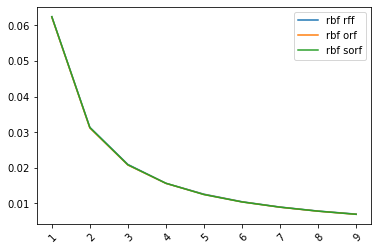

In [6]:
mse, classifiers, ratio_d = calculate_mean_square_error(vector_letters)

for clfn in classifiers.keys(): 
    pl.plot(np.arange(len(ratio_d)), mse[clfn], label=clfn)
pl.axes().set_xticks(np.arange(len(ratio_d)))
pl.axes().set_xticklabels(ratio_d)
pl.setp(pl.axes().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
pl.legend()

In [7]:
import h5py
with h5py.File("usps.h5", 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

In [10]:
X_tr

array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.1645, 0.086 , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]],
      dtype=float32)

sampler:  rbf rff n_components: 256
--- 1.5488560199737549 seconds ---
sampler:  rbf rff n_components: 512
--- 1.8630156517028809 seconds ---
sampler:  rbf rff n_components: 768
--- 1.8061699867248535 seconds ---
sampler:  rbf rff n_components: 1024
--- 2.094428777694702 seconds ---
sampler:  rbf rff n_components: 1280
--- 2.3317325115203857 seconds ---
sampler:  rbf rff n_components: 1536
--- 2.5491790771484375 seconds ---
sampler:  rbf rff n_components: 1792
--- 2.469392776489258 seconds ---
sampler:  rbf rff n_components: 2048
--- 2.7905375957489014 seconds ---
sampler:  rbf rff n_components: 2304
--- 2.985013961791992 seconds ---
sampler:  rbf orf n_components: 256
--- 1.7572972774505615 seconds ---
sampler:  rbf orf n_components: 512
--- 1.7353565692901611 seconds ---
sampler:  rbf orf n_components: 768
--- 1.9009177684783936 seconds ---
sampler:  rbf orf n_components: 1024
--- 2.0914225578308105 seconds ---
sampler:  rbf orf n_components: 1280
--- 2.368635416030884 seconds ---
sa

c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
c:\proyectos\sklearn-kdcrf\venv\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

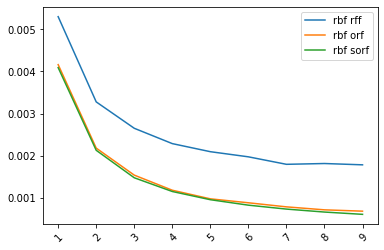

In [8]:
mse, classifiers, ratio_d = calculate_mean_square_error(X_tr)

for clfn in classifiers.keys(): 
    pl.plot(np.arange(len(ratio_d)), mse[clfn], label=clfn)
pl.axes().set_xticks(np.arange(len(ratio_d)))
pl.axes().set_xticklabels(ratio_d)
pl.setp(pl.axes().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
pl.legend()